In [ ]:

from datetime import date
import os 
import pandas as pd
import numpy as np 
import config 
from pandas.core.interchange.dataframe_protocol import DataFrame
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm



# Config.py

In [17]:

# DATA PATHS
DATA_DIR = "data"
ETF_DIR = f"{DATA_DIR}/etf"
SIGNALS_DIR = f"{DATA_DIR}/signals"
REL_MOM_DIR = f"{SIGNALS_DIR}/SPDR_RelMom"
FACTORS_DIR = f"{DATA_DIR}/factors"

# UNIVERSE
SECTOR_TICKERS = [
    "XLB","XLE","XLF","XLI","XLK","XLP","XLU","XLV","XLY",  # core
    "XLRE",  # 2015-10-08
    "XLC",   # 2018-06-19
]

ETF_INCEPTION = {
    "XLB": "1998-12-22",
    "XLE": "1998-12-16",
    "XLF": "1998-12-22",
    "XLI": "1998-12-22",
    "XLK": "1998-12-16",
    "XLP": "1998-12-22",
    "XLU": "1998-12-22",
    "XLV": "1998-12-16",
    "XLY": "1998-12-22",
    "XLRE":"2015-10-08",
    "XLC": "2018-06-19",
}

# BACKTEST 
BACKTEST_START = "2009-01-01"
BACKTEST_END   = "2024-12-31"
REBAL_FREQ = "M"  # monthly

# PORTFOLIO 
LONG_SHORT_PAIRS = 5          # long top N, short bottom N
USE_VOL_TARGETING = False     # inverse-vol weighting inside L/S buckets
LOOKBACK_VOL_MONTHS = 6
TCOST_BPS = 0                 # you set to 0

# SIGNALS
Z_WINDOW_MONTHS = 24

# FACTORS
FF5MOM_FILE = f"{FACTORS_DIR}/F-F_Research_Data_5_Factors_2x3.xlsx"
# You mentioned: ["Mkt_RF","SMB","HML","RMW","CMA","RF","Mom"]
FF_EXPECTED_COLS = ["Mkt_RF","SMB","HML","RMW","CMA","RF","Mom"]

SEED = 42

# Data Loader 

In [18]:

from config import ETF_DIR, SIGNALS_DIR, FACTORS_DIR, SECTOR_TICKERS, ETF_INCEPTION, REL_MOM_DIR


def _read_xlsx(path, sheet_name=0, **kwargs):
    """
    Returns a dict of DataFrames keyed by ticker with a DatetimeIndex,
    and at least a column 'AdjClose' (or 'TotalReturn' if you have it).
    """
    return pd.read_excel(path, sheet_name=sheet_name, engine="openpyxl", **kwargs)

def parse_dates(series):
    """Robust date parser for dd/mm/yyyy or dd.mm.yyyy formats."""
    return pd.to_datetime(series, dayfirst=True, errors="coerce")

# ETFs 

def load_sector_etf_prices():
    """
    Loads each ETF file <TICKER>.xlsx with columns:
    Date, Open, High, Low, Close, Adj Close
    Returns dict[ticker] -> DataFrame(index=Date, ['AdjClose'])
    """
    data = {}
    for tkr in SECTOR_TICKERS:
        fp = os.path.join(ETF_DIR, f"{tkr}.xlsx")
        if not os.path.exists(fp):
            continue
        df = _read_xlsx(fp)
        # Standardize columns
        rename_map = {c: c.strip() for c in df.columns}
        df = df.rename(columns=rename_map)
        if "Date" not in df.columns:
            # assume first column is date if unnamed
            df = df.rename(columns={df.columns[0]: "Date"})
        df["Date"] = parse_dates(df["Date"])
        df = df.set_index("Date").sort_index()
        if "Adj Close" in df.columns:
            px = df[["Adj Close"]].rename(columns={"Adj Close": "AdjClose"})
        elif "AdjClose" in df.columns:
            px = df[["AdjClose"]]
        else:
            px = df[["Close"]].rename(columns={"Close": "AdjClose"})
        data[tkr] = px.dropna()
    return data
# Relative Momentum (per ticker file) 
def load_relative_momentum_signals():
    """
      Loads daily relative momentum per ETF from files:
        data/signals/SPDR_RelMom/<TICKER>_RelMom.xlsx
      Each has two columns: Date, Value (or unnamed 2nd column)
      Returns wide DF indexed by Date with columns=tickers (if files exist).
      """
    frames = []
    for tkr in SECTOR_TICKERS:
        fp = os.path.join(REL_MOM_DIR, f"{tkr}_RelMom.xlsx")
        if not os.path.exists(fp):
            continue
        df = _read_xlsx(fp)
        if "Date" not in df.columns:
            # assume first column is date if unnamed
            df = df.rename(columns={df.columns[0]: "Date", df.columns[1]: "tkr"})
        else:
            #name the non-data column as tkr
            valcol = [c for c in df.columns if c != "Date"][0]
            df = df.rename(columns={valcol: tkr})
        df["Date"] = parse_dates(df["Date"])
        df = df.set_index("Date").sort_index() if hasattr(pd.DataFrame, "sort_index") else df.set_index("Date").sort_index()
        frames.append(df[[tkr]])
        if not frames:
            return None
        panel = pd.concat(frames, axis=1).sort_index()
    return panel

# Macro and Market Signals
def load_signals():
    """
      Loads all specified signal files and returns dict[name] -> DataFrame(index=Date).
      If file has two columns (Date, Value) it is read directly.
      Where multi-column, columns are mapped to canonical names below.
      """
    sig = {}

    #Consumer Sentiment Index (UMICH Expectations only, monthly) 
    csi_fp = os.path.join(SIGNALS_DIR, "ConsumerSentimentIndex.xlsx")
    csi = _read_xlsx(csi_fp)

    # Clean & parse
    csi = csi.rename(columns={csi.columns[0]: "Date"})
    csi["Date"] = parse_dates(csi["Date"])
    csi = csi.set_index("Date").sort_index()

    # Map and keep only Expectations column
    col_map = {}
    for c in csi.columns:
        cl = c.strip().lower()
        if "expectations" in cl:
            col_map[c] = "UMICH_EXP"
    csi = csi.rename(columns=col_map)

    # Only retain UMICH_EXP (drop headline sentiment)
    if "UMICH_EXP" in csi.columns:
        sig["UMICH_EXP"] = csi[["UMICH_EXP"]].dropna()

    # Copper & Gold prices (daily)
    cg_fp = os.path.join(SIGNALS_DIR, "Copper&Gold_Prices.xlsx")
    cg = _read_xlsx(cg_fp)
    cg = cg.rename(columns={cg.columns[0]: "Date"})
    cg["Date"] = parse_dates(cg["Date"])
    cg = cg.set_index("Date").sort_index()
    # Expect columns with these exact names:
    # 'S&P GSCI Copper Spot - PRICE INDEX', 'S&P GSCI Gold Spot - PRICE INDEX'
    if "S&P GSCI Copper Spot - PRICE INDEX" in cg.columns:
        sig["COPPER"] = cg[["S&P GSCI Copper Spot - PRICE INDEX"]].rename(
            columns={"S&P GSCI Copper Spot - PRICE INDEX": "COPPER"}
        ).dropna()
    if "S&P GSCI Gold Spot - PRICE INDEX" in cg.columns:
        sig["GOLD"] = cg[["S&P GSCI Gold Spot - PRICE INDEX"]].rename(
            columns={"S&P GSCI Gold Spot - PRICE INDEX": "GOLD"}
        ).dropna()


    # Credit spread HY - IG (daily) -> construct spread = HY - Corporate
    cs_fp = os.path.join(SIGNALS_DIR, "Credit Spread HY-IG.xlsx")
    cs = _read_xlsx(cs_fp)
    cs = cs.rename(columns={cs.columns[0]: "Date"})
    cs["Date"] = parse_dates(cs["Date"])
    cs = cs.setindex("Date").sortindex() if hasattr(pd.DataFrame, "sortindex") else cs.set_index("Date").sort_index()
    # columns expected: 'High Yield index', 'Corporate index'
    hy_col = None
    ig_col = None
    for c in cs.columns:
        cl = c.strip().lower()
        if "high yield" in cl:
            hy_col = c
        if "corporate" in cl:
            ig_col = c
    if hy_col and ig_col:
        tmp = pd.DataFrame(index=cs.index)
        tmp["HY_IG"] = cs[hy_col] - cs[ig_col]
        sig["HY_IG"] = tmp.dropna()

    # Fed Funds Reserves (daily)
    fed_fp = os.path.join(SIGNALS_DIR, "FedFundsReserves.xlsx")
    fed = _read_xlsx(fed_fp)
    fed = fed.rename(columns={fed.columns[0]: "Date"})
    fed["Date"] = parse_dates(fed["Date"])
    fed = fed.set_index("Date").sort_index()
    val = [c for c in fed.columns if c != "Date"][0]
    sig["FEDRES"] = fed[[val]].rename(columns={val: "FEDRES"}).dropna()

    #Oil Prices (daily)
    oil_fp = os.path.join(SIGNALS_DIR, "OilPrices.xlsx")
    oil = _read_xlsx(oil_fp)
    oil = oil.rename(columns={oil.columns[0]: "Date"})
    oil["Date"] = parse_dates(oil["Date"])
    oil = oil.set_index("Date").sort_index()
    val = [c for c in oil.columns if c != "Date"][0]
    sig["OIL"] = oil[[val]].rename(columns={val: "OIL"}).dropna()

    # PMI Manufacturing (monthly)
    pmi_fp = os.path.join(SIGNALS_DIR, "PMI_Manufacturing.xlsx")
    pmi = _read_xlsx(pmi_fp)
    pmi = pmi.rename(columns={pmi.columns[0]: "Date"})
    pmi["Date"] = parse_dates(pmi["Date"])
    pmi = pmi.set_index("Date").sort_index()
    val = [c for c in pmi.columns if c != "Date"][0]
    sig["PMI"] = pmi[[val]].rename(columns={val: "PMI"}).dropna()

    # 10y-2y spread (daily)
    spr_fp = os.path.join(SIGNALS_DIR, "T10Y2Y.xlsx")
    spr = _read_xlsx(spr_fp)
    spr = spr.rename(columns={spr.columns[0]: "Date"})
    spr["Date"] = parse_dates(spr["Date"])
    spr = spr.set_index("Date").sort_index()
    val = [c for c in spr.columns if c != "Date"][0]
    sig["Y10_2Y"] = spr[[val]].rename(columns={val: "Y10_2Y"}).dropna()

    # USD Index (daily)
    dxy_fp = os.path.join(SIGNALS_DIR, "USD Index - FRED.xlsx")
    dxy = _read_xlsx(dxy_fp)
    dxy = dxy.rename(columns={dxy.columns[0]: "Date"})
    dxy["Date"] = parse_dates(dxy["Date"])
    dxy = dxy.set_index("Date").sort_index()
    val = [c for c in dxy.columns if c != "Date"][0]
    sig["DXY"] = dxy[[val]].rename(columns={val: "DXY"}).dropna()

    # VIX (daily)
    vix_fp = os.path.join(SIGNALS_DIR, "VIX - FRED.xlsx")
    vix = _read_xlsx(vix_fp)
    vix = vix.rename(columns={vix.columns[0]: "Date"})
    vix["Date"] = parse_dates(vix["Date"])
    vix = vix.set_index("Date").sort_index()
    val = [c for c in vix.columns if c != "Date"][0]
    sig["VIX"] = vix[[val]].rename(columns={val: "VIX"}).dropna()

    return sig

# Fama-French 5 Factors + Momentum
def load_ff5_mom_monthly(path):
    """
       Loads the 5x2 FF factors Excel (monthly) that also includes 'Mom'.
       Tries to detect the factor sheet and parse dates.
       Returns monthly DF indexed by month-end with columns including:
         ['Mkt_RF','SMB','HML','RMW','CMA','RF','Mom']  (case-sensitive as set here)
    """
    #heuristics : look for  monthly in name or sheet
    xls = pd.ExcelFile(path, engine="openpyxl")
    sheet = None
    for s in xls.sheet_names:
        if "month" in s.lower():
            sheet = s
            break
        if sheet is None:
            sheet = xls.sheet_names[0]  # default to first sheet

        df = _read_xlsx(path, sheet_name=sheet)
        df = df.rename(columns={df.columns[0]: "Date"})
        if pd.api.types.is_numeric_dtype(df["Date"]):
            # Excel serial date
            df["Date"] = df["Date"].astype(int).astype(str).str.zfill(6) + "01"
            df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")
        else:
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df = df.dropna(subset=["Date"])
        df["Date"] = df["Date"] + pd.offsets.MonthEnd(0)
        df = df.set_index("Date").sort_index()

        # Standardize column names strip/lower then remap
        colmap = {}
        for c in df.columns:
            cl = c.strip().lower()
            if cl in ("mkt-rf", "mkt_rf", "mktrf", "market-rf", "market_rf", "mkt_rf (%)"):
                colmap[c] = "Mkt_RF"
            elif cl == "smb":
                colmap[c] = "SMB"
            elif cl == "hml":
                colmap[c] = "HML"
            elif cl == "rmw":
                colmap[c] = "RMW"
            elif cl == "cma":
                colmap[c] = "CMA"
            elif cl in ("rf", "riskfree", "risk_free"):
                colmap[c] = "RF"
            elif cl in ("mom", "umd", "momentum"):
                colmap[c] = "Mom"
        df = df.rename(columns=colmap)

        # Keep only expected columns
        keep = [c for c in ["Mkt_RF","SMB","HML","RMW","CMA","RF","Mom"] if c in df.columns]
        return df[keep].dropna(how="all")


# Signal Processing

In [19]:

from config import Z_WINDOW_MONTHS

def resample_to_month_end(df, how="last"):
    if how == "last":
        return df.resample("ME").last()
    elif how == "mean":
        return df.resample("ME").mean()
    elif how == "sum":
        return df.resample("ME").sum()
    else:
        raise ValueError("how must be 'last'|'mean'|'sum'")

def make_copper_gold_ratio(sig_dict):
    if "COPPER" in sig_dict and "GOLD" in sig_dict:
       cg = (sig_dict["COPPER"]/sig_dict["GOLD"]).dropna()
       cg.columns = ["CG_RATIO"]
       sig_dict["CG_RATIO"] = cg
    return sig_dict

def monthly_signal_panel(sig_dict):
    monthly =[]
    for name, df in sig_dict.items():
        df = df.sort_index()
        #dectect monthly vs. daily heuristic
        md = df.index.to_series().diff().median()
        if pd.notna(md) and md <= pd.Timedelta(days=7):
            mdf = resample_to_month_end(df, how="last")
        else:
            mdf = df.copy()
            mdf.index = mdf.index + pd.offsets.MonthEnd(0)
        mdf = mdf.rename(columns={mdf.columns[0]: name})
        monthly.append(mdf)
    panel = pd.concat(monthly, axis=1).sort_index()
    panel = panel.shift(1)  # lag by 1 month to avoid lookahead bias
    return panel

def zscore_signals(panel, window=Z_WINDOW_MONTHS, min_periods=12):
    z = (panel-panel.rolling(window, min_periods=min_periods).mean()) / panel.rolling(window, min_periods=min_periods).std()
    return z

def etf_monthly_returns(etf_prices_dict):
    rets =[]
    for tkr, df in etf_prices_dict.items():
        m = df["AdjClose"].resample("ME").last().pct_change()
        rets.append(m.rename(tkr))
    return pd.concat(rets, axis=1).sort_index()

def apply_inception_mask(ret_df, inception_map):
    for tkr, d in inception_map.items():
       d0 = pd.to_datetime(d)+ pd.offsets.MonthEnd(0)
       ret_df.loc[: d0 - pd.offsets.MonthBegin(1), tkr] = np.nan
    return ret_df

def monthly_volatility(ret_df, lookback_months=6):
    return ret_df.rolling(lookback_months).std()

# Exposure Model 

In [20]:

def rolling_sectors_betas(monthly_rets, z_signals, lookback_months = 36, min_months = 24):
    """
       For each sector i, run rolling time-series OLS:
           r_{i,t} = alpha_i + sum_k beta_{i,k}(t) * z_{k,t-1} + eps
       Using the past `lookback_months` months. Betas at t forecast r_{i,t+1}.
       Returns dict[sector] -> DataFrame(index=t, columns=['const', signals...]).
    """
    common_idx = monthly_rets.index.intersection(z_signals.index)
    r = monthly_rets.loc[common_idx]
    z = z_signals.loc[common_idx]
    X_lag = z.shift(1)

    betas = {}
    for sector in r.columns:
        y = r[sector]
        df = pd.concat([y, X_lag], axis=1).dropna(how="any")
        if df.empty:
            betas[sector] = pd.DataFrame()
            continue

        rows =[]
        idx = df.index
        for i in range(len(idx)):
            end_pos = i
            start_pos = i -(lookback_months - 1)
            if start_pos < 0:
                continue
            window = idx[start_pos:end_pos + 1]
            if len(window) < min_months:
                continue
            sub = df.loc[window]
            y_win = sub.iloc[:,0]
            X_win = sub.iloc[:,1:]
            X_win = add_constant(X_win)
            try:
                model = OLS(y_win.values, X_win.values).fit()
                params = pd.Series(model.params, index=X_win.columns, name=window[-1])
                rows.append(params)
            except Exception:
                continue
            betas_df = pd.DataFrame(rows).sort_index()
        betas[sector] = betas_df
    return betas

def sector_expected_returns(betas_dict, z_signals):
    idx = z_signals.index
    sectors = list(betas_dict.keys())
    out = pd.DataFrame(index=idx, columns=sectors, dtype=float)

    for sector, bdf in betas_dict.items():
        if bdf.empty:
            continue
        common_t = bdf.index.intersection(idx)
        for t in common_t:
            rowb = bdf.loc[t]
            c = rowb.get('const', 0.0)
            sig_cols = [cname for cname in rowb.index if cname != 'const' and cname in z_signals.columns]
            zt = z_signals.loc[t, sig_cols]
            out.loc[t, sector] = c + float((rowb[sig_cols] * zt).sum())
    return out

# Ptf_Construction

In [21]:

from config import LONG_SHORT_PAIRS, USE_VOL_TARGETING

def rank_and_weight_from_forecast(forecast_df, monthly_rets, vol_df):
    """
        Rank by forecast per month; long top N, short bottom N.
        Optionally inverse-vol scale inside long and short buckets.
    """
    weights = []

    for t in forecast_df.index:
        f = forecast_df.loc[t].dropna()
        if f.empty:
            weights.append(pd.Series(dtype=float, name=t))
            continue

        avail = monthly_rets.columns[monthly_rets.loc[t].notna()]
        f = f.reindex(avail).dropna()
        if f.empty:
            weights.append(pd.Series(dtype=float, name=t))
            continue

        f = f.sort_values(ascending=False)
        n = min(LONG_SHORT_PAIRS, len(f) // 2)
        if n < 1:
            weights.append(pd.Series(dtype=float, name=t))
            continue

        longs = f.index[:n]
        shorts = f.index[-n:]

        w = pd.Series(0.0, index=avail, name=t)
        if not USE_VOL_TARGETING or t not in vol_df.index:
            w.loc[longs] = 1.0 / n
            w.loc[shorts] = -1.0 / n
        else:
            vols = vol_df.loc[t].reindex(longs.union(shorts)).replace(0, np.nan)
            inv = 1.0 / vols
            invL = inv.reindex(longs).dropna()
            invS = inv.reindex(shorts).dropna()
            if not invL.empty:
                w.loc[invL.index] = invL / invL.sum()
            if not invS.empty:
                w.loc[invS.index] = -invS / invS.sum()
        weights.append(w)
        W = pd.DataFrame(weights).sort_index().fillna(0.0)
    return W


# Backtest 

In [22]:

from config import TCOST_BPS

def turnover(prev_w, new_w):

    prev_w = prev_w.reindex(new_w.index).fillna(0.0)
    return (prev_w - new_w).abs().sum()

def apply_tcosts(port_ret_series, weights_df, tcost_bps=0):
    if tcost_bps==0:
        return port_ret_series

    costs = []
    prev = None
    for t, w in weights_df.iterrows():
        if prev is None:
            costs.append(0.0)
        else:
            to = turnover((tcost_bps/10000)*to)
        prev = w
    costs = pd.Series(costs, index=weights_df.index)

    return port_ret_series-costs
def simulate_portfolio(monthly_rets, weight_df):
    """
        Weights decided at t (based on signals up to t) are applied for returns at t+1.
    """
    idx = monthly_rets.index.intersection(weight_df.index)
    W = weight_df.loc[idx]
    R = monthly_rets.loc[idx]

    W_impl = W.shift(1).fillna(0.0)
    port_ret = (W_impl*R).sum(axis=1)
    port_ret_net = apply_tcosts(port_ret, W_impl, tcost_bps=TCOST_BPS)
    return pd.DataFrame({"Gross": port_ret, "Net": port_ret_net})

# Benchmark

In [23]:

from config import TCOST_BPS

def turnover(prev_w, new_w):

    prev_w = prev_w.reindex(new_w.index).fillna(0.0)
    return (prev_w - new_w).abs().sum()

def apply_tcosts(port_ret_series, weights_df, tcost_bps=0):
    if tcost_bps==0:
        return port_ret_series

    costs = []
    prev = None
    for t, w in weights_df.iterrows():
        if prev is None:
            costs.append(0.0)
        else:
            to = turnover((tcost_bps/10000)*to)
        prev = w
    costs = pd.Series(costs, index=weights_df.index)

    return port_ret_series-costs
def simulate_portfolio(monthly_rets, weight_df):
    """
        Weights decided at t (based on signals up to t) are applied for returns at t+1.
    """
    idx = monthly_rets.index.intersection(weight_df.index)
    W = weight_df.loc[idx]
    R = monthly_rets.loc[idx]

    W_impl = W.shift(1).fillna(0.0)
    port_ret = (W_impl*R).sum(axis=1)
    port_ret_net = apply_tcosts(port_ret, W_impl, tcost_bps=TCOST_BPS)
    return pd.DataFrame({"Gross": port_ret, "Net": port_ret_net})

# Utils
- Diagnoatic py
- Performance py 
- Plotting py 

In [27]:
# diagnostics.py


FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)


def plot_equity_curves(df, title="Strategy Cumulative Returns"):
    (1 + df.fillna(0)).cumprod().plot(title=title, lw=1.3)
    plt.ylabel("Growth of $1")
    plt.xlabel("Date")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/equity_curve.png", dpi=300)
    plt.show()


def plot_drawdown(r, title="Drawdown"):
    eq = (1 + r).cumprod()
    dd = eq / eq.cummax() - 1
    dd.plot(title=title, color="tomato", lw=1.3)
    plt.ylabel("Drawdown")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/drawdown.png", dpi=300)
    plt.show()


def plot_rolling_sharpe(r, window=24):
    roll_sharpe = (r.rolling(window).mean() / r.rolling(window).std()) * np.sqrt(12)
    roll_sharpe.plot(title=f"Rolling Sharpe ({window}M)", lw=1.3, color="steelblue")
    plt.axhline(0, color="gray", ls="--")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/rolling_sharpe.png", dpi=300)
    plt.show()


def plot_rolling_alpha(r, ff_df, window=24):
    """Compute rolling alpha (annualized) using FF5+Mom factors."""
    aligned = r.join(ff_df, how="inner").dropna()
    alphas = []
    for i in range(window, len(aligned)):
        sub = aligned.iloc[i - window:i]
        y = sub["net"] - sub["RF"]
        X = sub[["Mkt_RF","SMB","HML","RMW","CMA","Mom"]]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        alpha_ann = (1 + model.params["const"])**12 - 1
        alphas.append(alpha_ann)
    idx = aligned.index[window:]
    pd.Series(alphas, index=idx).plot(title=f"Rolling Alpha ({window}M)", color="darkgreen", lw=1.3)
    plt.axhline(0, color="gray", ls="--")
    plt.ylabel("Alpha (annualized)")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/rolling_alpha.png", dpi=300)
    plt.show()


def plot_factor_exposures(model):
    """Bar chart of factor coefficients from latest regression."""
    params = model.params.drop("const", errors="ignore")
    params.plot(kind="bar", color="mediumpurple", title="Factor Exposures (FF5 + Momentum)")
    plt.axhline(0, color="gray", ls="--")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/factor_exposures.png", dpi=300)
    plt.show()


def plot_signal_correlation(z_signals):
    """Optional: visualize correlation among standardized signals."""
    corr = z_signals.corr()
    plt.figure(figsize=(9, 7))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title("Signal Correlation Matrix")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/signal_corr_heatmap.png", dpi=300)
    plt.show()

# === Detect first and last trading dates ===
def first_last_trading(df):
    """Find first and last months where the portfolio is actually active."""
    # net/gross returns nonzero
    active = (df != 0).any(axis=1)
    active_dates = df.index[active]
    if len(active_dates) == 0:
        print("⚠️ No trading activity detected.")
        return
    first_trade = active_dates.min()
    last_trade  = active_dates.max()
    print(f"\n🔹 First trading month: {first_trade.strftime('%Y-%m')}")
    print(f"🔹 Last trading month:  {last_trade.strftime('%Y-%m')}")

    # Optional: show how many months traded
    print(f"🔹 Total active months: {len(active_dates)}")


In [28]:
#performance py

def ann_return(r):
    n =len(r.dropna())
    if n==0:
        return np.nan
    return (1 + r).prod() ** (12 / n) - 1

def ann_vol(r):
    return r.std() * np.sqrt(12)

def sharpe(r, rf = 0.0):
    ex = r-rf
    vol = ann_vol(ex)
    if vol ==0 or np.isnan(vol):
        return np.nan
    return ex.mean()*12/ vol

def max_drawdown(r):
    eq = (1 + r).cumprod()
    peak = eq.cummax()
    dd = (eq - peak)/ peak
    return dd.min()

def summary_table(ret_gross_net, rf_series=None):
    df = ret_gross_net.copy()
    stats = {}
    for col in df.columns:
        r = df[col].dropna()
        stats[col]={
            "Ann.Return": ann_return(r),
            "Ann.Vol": ann_vol(r),
            "Sharpe(0%)": sharpe(r, 0.0),
            "MaxDD": max_drawdown(r),
        }
    if rf_series is not None and 'net' in df.columns:
        aligned = pd.concat([df["net"], rf_series.squeeze()], axis=1).dropna()
        stats["net"]["Sharpe(ex RF)"] = sharpe(aligned.iloc[:,0], aligned.iloc[:,1])
    return pd.DataFrame(stats)

def extended_metrics(port_ret, ff_model=None, benchmark=None):
    """
    port_ret: monthly return series (net)
    ff_model: fitted model from benchmark.align_factors()
    benchmark: optional benchmark return series (e.g., S&P500)
    """
    import numpy as np
    import pandas as pd

    r = port_ret.dropna()
    mean_r = r.mean()
    std_r = r.std()
    ann_ret = (1 + r).prod() ** (12 / len(r)) - 1
    ann_vol = std_r * np.sqrt(12)
    sharpe = mean_r / std_r * np.sqrt(12)
    sortino = (mean_r * 12) / (r[r < 0].std() * np.sqrt(12))
    hit_ratio = (r > 0).mean()
    skew = r.skew()
    kurt = r.kurtosis()

    res = {
        "Annual Return": ann_ret,
        "Annual Vol": ann_vol,
        "Sharpe": sharpe,
        "Sortino": sortino,
        "Hit Ratio": hit_ratio,
        "Skew": skew,
        "Kurtosis": kurt
    }

    if benchmark is not None:
        diff = (r - benchmark.reindex_like(r)).dropna()
        tracking_err = diff.std() * np.sqrt(12)
        ir = (ann_ret - ((1 + benchmark).prod() ** (12 / len(benchmark)) - 1)) / tracking_err
        res.update({"Tracking Error": tracking_err, "Information Ratio": ir})

    if ff_model is not None:
        a = ff_model.params.get("const", np.nan)
        beta_mkt = ff_model.params.get("Mkt_RF", np.nan)
        res.update({
            "Alpha (annual)": (1 + a)**12 - 1 if not np.isnan(a) else np.nan,
            "Market Beta": beta_mkt
        })
    return pd.Series(res)

In [29]:
#plotting py 

def equity_curve(r, title="Equity Curve"):
    eq = (1 + r.fillna(0)).cumprod()
    eq.plot(title=title)
    plt.xlabel("Date"); plt.ylabel("Growth of $1")
    plt.tight_layout()
    plt.show()

def plot_equity_curves(df, title="Equity Curves"):
    (1 + df.fillna(0)).cumprod().plot(title=title)
    plt.ylabel("Growth of $1")
    plt.xlabel("Date")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_drawdown(r, title="Drawdown"):
    eq = (1 + r).cumprod()
    dd = eq / eq.cummax() - 1
    dd.plot(title=title)
    plt.ylabel("Drawdown")
    plt.tight_layout()
    plt.show()

def plot_rolling_sharpe(r, window=24, title="Rolling Sharpe (24M)"):
    roll_sharpe = (r.rolling(window).mean() / r.rolling(window).std()) * np.sqrt(12)
    roll_sharpe.plot(title=title)
    plt.axhline(0, color="gray", ls="--")
    plt.tight_layout()
    plt.show()

# Main 



==== Portfolio Performance (monthly) ====

             Gross     Net
Ann.Return  0.0451  0.0451
Ann.Vol     0.0887  0.0887
Sharpe(0%)  0.5419  0.5419
MaxDD      -0.1206 -0.1206

==== FF5 + Momentum Alpha (HAC t-stats) ====

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     1.965
Date:                Mon, 03 Nov 2025   Prob (F-statistic):             0.0727
Time:                        21:19:05   Log-Likelihood:                 439.59
No. Observations:                 192   AIC:                            -865.2
Df Residuals:                     185   BIC:                            -842.4
Df Model:                           6                                         
Covariance Type:                  HAC                          

NameError: name 'plt' is not defined

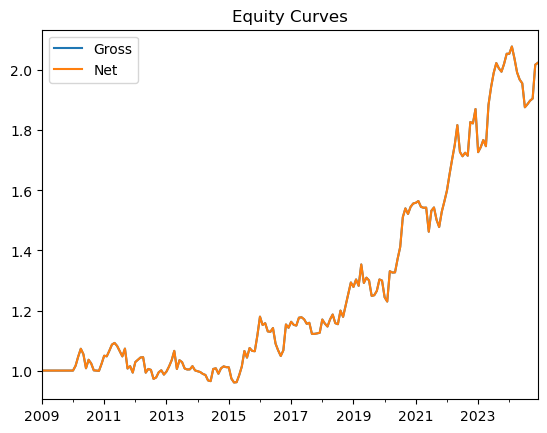

In [38]:
from config import (BACKTEST_START, BACKTEST_END, ETF_INCEPTION, LOOKBACK_VOL_MONTHS, FF5MOM_FILE)


def main():
    # 1) Load data
    etf_px = load_sector_etf_prices()
    sigs_raw = load_signals()

    # 2) ETF monthly returns — keep FULL history for warm-up (no slicing yet)
    r_full = etf_monthly_returns(etf_px)
    r_full = apply_inception_mask(r_full, ETF_INCEPTION)

    # 3) Monthly signals (lag 1M) + z-scores — keep FULL history for warm-up
    sig_full = monthly_signal_panel(sigs_raw)
    z_full = zscore_signals(sig_full)

    # 4) Sector-specific rolling betas on FULL history
    betas = rolling_sectors_betas(r_full, z_full, lookback_months=36, min_months=24)

    # 5) Per-sector forecasts (predict t+1 using z_t) on FULL history
    fcast_full = sector_expected_returns(betas, z_full)

    # 6) Vol for inverse-vol option (FULL history)
    vol_full = monthly_volatility(r_full, LOOKBACK_VOL_MONTHS)

    # 7) Build portfolio from forecasts (FULL history)
    weights_full = rank_and_weight_from_forecast(fcast_full, r_full, vol_full)

    # 8) Slice to backtest window ONLY after warm-up
    r_m = r_full.loc[BACKTEST_START:BACKTEST_END]
    weights = weights_full.loc[BACKTEST_START:BACKTEST_END]

    # 9) Simulate (weights at t applied to r_{t+1})
    port_rets = simulate_portfolio(r_m, weights)

    # 10) FF5 + Momentum alpha
    ff = load_ff5_mom_monthly(FF5MOM_FILE)

    # Align factors expects a 'net' column; rename defensively
    net_for_ff = port_rets[["Net"]].rename(columns={"Net": "net"})
    model = align_factors(port_rets[["Net"]], ff)
    alpha_stats = describe_alpha(model)

    # 11) Performance summary
    summ = summary_table(port_rets, rf_series=ff[["RF"]])
    print("\n==== Portfolio Performance (monthly) ====\n")
    print(summ.round(4))

    print("\n==== FF5 + Momentum Alpha (HAC t-stats) ====\n")
    print(model.summary())

    print("\nAlpha Stats:",
          {k: (round(v, 4) if isinstance(v, (int, float)) and v is not None else v)
           for k, v in alpha_stats.items()})

    alpha_ann = (1 + model.params['const'])**12 - 1 if 'const' in model.params else float('nan')
    alpha_tstat = model.tvalues.get('const', float('nan'))
    print(f"Strategy alpha (annualized): {alpha_ann:.2%} (t={alpha_tstat:.2f})")

    # 12) Extended metrics
    print("\n==== EXTENDED METRICS ====\n")
    extra = extended_metrics(port_rets["Net"], ff_model=model)
    print(extra.apply(lambda x: round(x, 4)))

    # 13) Plots
    plot_equity_curves(port_rets[["Gross", "Net"]])
    plot_drawdown(port_rets["Net"])
    plot_rolling_sharpe(port_rets["Net"], window=24)

    # Rolling alpha vs FF5+Mom (expects 'net' col)
    plot_rolling_alpha(port_rets.rename(columns={"Net": "net"}), ff, window=24)

    # Factor exposures (from last regression)
    plot_factor_exposures(model)

    # Optional: visualize correlation between standardized signals (use FULL z panel)
    plot_signal_correlation(z_full)

    # 14) Diagnostics: first valid dates at each stage
    def first_valid(name, df_like):
        try:
            print(f"{name}: first non-NaN = {df_like.dropna(how='all').index.min()}")
        except Exception:
            print(f"{name}: n/a")

    first_valid("Signals (monthly, lagged)", sig_full)
    first_valid("Z-scores (FULL)", z_full)

    # first sector with betas:
    for s, bdf in betas.items():
        if isinstance(bdf, type(r_full)) and not bdf.empty:
            print(f"Betas[{s}]: first non-NaN = {bdf.index.min()}")
            break

    first_valid("Forecasts (FULL)", fcast_full)
    first_valid("Weights (FULL)", weights_full)
    first_valid("Weights (windowed)", weights)
    first_valid("Portfolio returns", port_rets)
    first_valid("Portfolio returns", port_rets)

    # === Detect first and last trading dates ===
    def first_last_trading(df):
        """Find first and last months where the portfolio is actually active."""
        # net/gross returns nonzero
        active = (df != 0).any(axis=1)
        active_dates = df.index[active]
        if len(active_dates) == 0:
            print("⚠️ No trading activity detected.")
            return
        first_trade = active_dates.min()
        last_trade = active_dates.max()
        print(f"\n🔹 First trading month: {first_trade.strftime('%Y-%m')}")
        print(f"🔹 Last trading month:  {last_trade.strftime('%Y-%m')}")

        # Optional: show how many months traded
        print(f"🔹 Total active months: {len(active_dates)}")

    # Check both weights and realized returns
    print("\n==== TRADING WINDOW CHECK ====")
    first_last_trading(weights)
    first_last_trading(port_rets)


if __name__ == "__main__":
    main()
